<a href="https://colab.research.google.com/github/M-H-Amini/Image-Compression-Using-PCA/blob/master/ImageCompression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  In The Name Of ALLAH
<h2>
Image Compression With Principal Components Analysis (PCA)
</h2>

**Written By: Mohammad Hossein Amini (mhamini@aut.ac.ir)**

In this project I'm gonna compress an image using the famous **Principal Component Analysis** or **PCA**. There are plenty of useful resources and textbooks to study the algorithm. In summary, We'll be partitioning the image into non-overlapping windows (for example of size 8$*$8). So after flattening each window, we have a column vector (64$*$1 in this case) for each window. By concatenating all these windows we have a big matrix, **X**, in which each column is a flattened window. PCA theory, in a statistical view, simply says that if we want to project each sample (window vector in our case) in a direction such that we have the most variance in that direction, we must project samples in the direction of the eigenvectors of the covariance matrix of the samples (**cov(X)**). So we can say that we have the most information in the direction of the eigenvectors of the covariance matrix of the data. 

I will use the image of my favorite mathematician, Gilbert Strang, Wishing him a long and healthy life.

Let's compress the image...

# Importing Stuff
We can do all our job with *cv2* and *numpy*, but we'll use *matplotlib* for displaying results here in the colab or in your IDE and *os* for a comaprison of sizes in the original and comressed images.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Turning The Image Into Windows
As I told you, first of all we turn our image into a bunch of non-overlapping windows of arbitrary size. So I'll implement **windowize** function such that it gets the image numpy array and the arbitrary size and turns the image into windows of that size. One of the assumptions of the *PCA* theorem is that samples are zero-mean. In case they aren't really zero-mean, we can simply subtract their mean from them without losing any generality. In the end we can add this mean again so that everything becomes ok! We would also normalize our data so that all of them are in the range of 0 and 1.

In [0]:
def windowize(image, size=(8, 8)):
  X = np.zeros((size[0]*size[1], 1))
  for i in range(image.shape[0]//size[0]):
    for j in range(image.shape[1]//size[1]):
      window = image[i*size[0]:(i+1)*size[0], j*size[1]:(j+1)*size[1]]
      window = np.reshape(window, (-1, 1))  #  Flattening the window into a column vector...
      X = np.concatenate((X, window), axis=1)
  X = X[:, 1:]/255.  #  Normalizing data...
  X -= np.reshape(np.mean(X, axis=1), (-1, 1))
  return X

#  Turning All Windows Into An Image
As we've been able to turn an image into windows, we must also be able to turn all windows beside each other and reconstruct the image again! So we implement the **dewindowize** function. It gets the big matrix of all windows in its columns and the number of windows in each row and column of the image as a tupple (for example (50,50) for an image with 50 windows in each column and each row). It also gets the window size. Finally it return the image numpy array.

In [0]:
def dewindowize(X, window_no, window_size=(8, 8)):
  image = np.zeros((window_no[0]*window_size[0], window_no[1]*window_size[1]))
  c = 0
  for i in range(window_no[0]):
    for j in range(window_no[1]):
      image[i*window_size[0]:(i+1)*window_size[0], j*window_size[1]:(j+1)*window_size[1]] = np.reshape(X[:, c:c+1], window_size)
      c+=1
  return image

In the following code we simply turn an image into windows of $8*8$ and reconstruct it again. Let's see how it works...

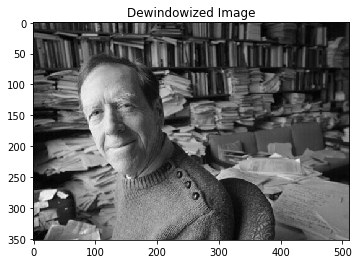

In [43]:
image = cv2.imread('gilbert.jpg', 0)
window_size = (8, 8)
window_no = (image.shape[0]//window_size[0], image.shape[1]//window_size[1])
X = windowize(image, window_size)
dewindowized_image = dewindowize(X, window_no, window_size)
plt.figure()
plt.title('Dewindowized Image')
plt.imshow(dewindowized_image, cmap='gray')
plt.show()

#  PCA Stuff
Now let's implement **PCA**. First of all, we'll implement **PCA** function. It gets data matrix(X in our case) such that each column of X is a sample. After finding their covariance matrix, we would find the eigenvectors and eigenvalues of the covariance matrix. So, again, by the PCA theorem we know that we have the most variance in projecting in the direction of the eigenvector with the most corresponding eigenvalue. We have the second most variance in projecting in the direction of the eigenvector with the second most corresponding eigenvalue. We just need the **n** eigencvectors (calling them principal axes) with n top corresponding eigenvalues. So our **PCA** function returns these eigenvectors with their corresponding eigenvalues.

In [0]:
def PCA(X, n):
  #  Finding covariance matrix...
  cov = np.dot(X, np.transpose(X))/X.shape[0]
  #  Finding eigenvalues and eigenvectors of the covariance matrix...
  evals, evecs = np.linalg.eig(cov)
  evecs = evecs.astype(float)
  evals = evals.astype(float)
  top_indexes = evals.argsort()[-n:][::-1]
  return evecs[:, top_indexes], evals[top_indexes]

After finding principal axes and their corresponding eigenvalues, we must be able to project our data in their direction. So we have **transform** function that gets data and principal axes and projects data in those principal axes to get the **principal components**. Note that no matter you give this function a single sample (column vector) or a big matrix of data, it gives you the correct result!

In [0]:
def transform(x, paxis):
  return np.dot(np.transpose(paxis), x) 

We must also be able to turn our principal components into original data (with high accuracy only, not full reconstrucion! Why? ;-)). So we implement **itransform** function. It gets principal components and principal axes and generates original data. 

In [0]:
def itransform(x, paxis):
  return np.dot(paxis, x)

Now let's find the principal axes and principal components of our windows! We just keep, for example, 10 largest of them.

In [0]:
paxis, pvals = PCA(X, 10)
X_transformed = transform(X, paxis)
X_itransformed = itransform(X_transformed, paxis)

Now we reconstruct our image with the itransformed data!

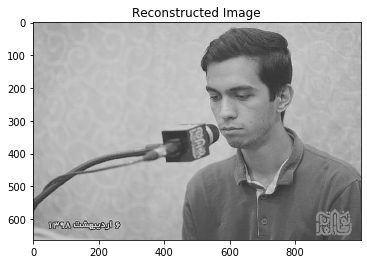

In [23]:
image_reconstructed = dewindowize(X_itransformed, window_no, window_size)
plt.figure()
plt.title('Reconstructed Image')
plt.imshow(image_reconstructed, cmap='gray')
plt.show()

# All-In-One!
Let's do all the job in one function! We'll implement **compress** function. It gets an image and number of principal axes to compress the image with, **n** and window_sizes, and returns the compressed image. Isn't that amazing?!

In [0]:
def compress(image, n, window_size=(8,8)):
  window_no = (image.shape[0]//window_size[0], image.shape[1]//window_size[1])
  X = windowize(image, window_size)
  paxis, pvals = PCA(X, n)
  X_transformed = transform(X, paxis)
  X_itransformed = itransform(X_transformed, paxis)
  image_reconstructed = dewindowize(X_itransformed, window_no, window_size)
  return image_reconstructed

# Test
Let's have a final test over our work!

We'll compress our image with different number of principal components and see the effect.

Original size:  36972
n:  1 size: 2511


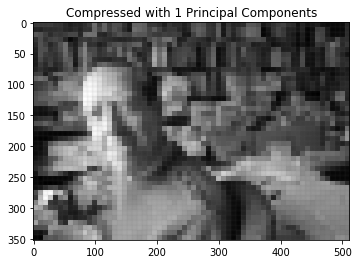

n:  2 size: 2563


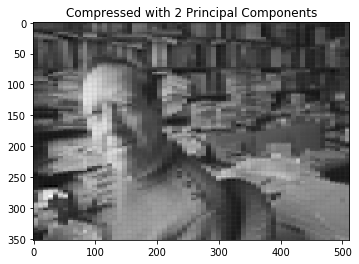

n:  3 size: 2651


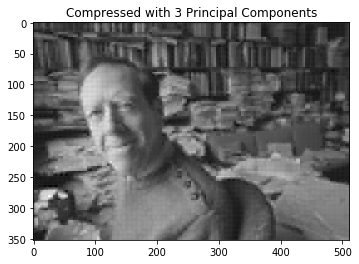

n:  4 size: 2652


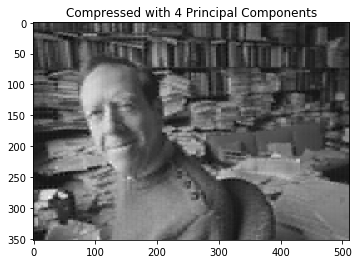

n:  5 size: 2675


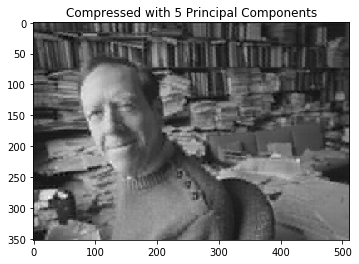

n:  6 size: 2702


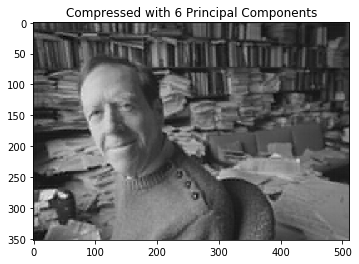

n:  7 size: 2703


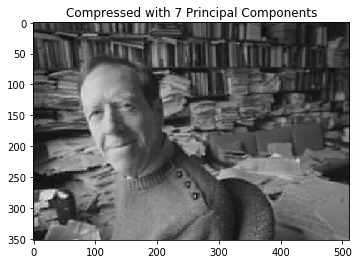

n:  8 size: 2717


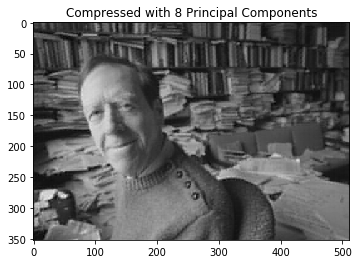

n:  9 size: 2718


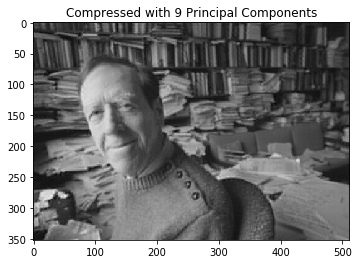

n:  10 size: 2699


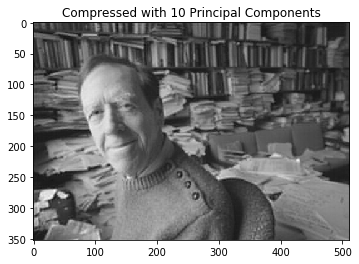

In [47]:
image = cv2.imread('gilbert.jpg', 0)
print('Original size: ', os.path.getsize('gilbert.jpg'))
ns = [i+1 for i in range(10)]
for i in ns:
  image_compressed = compress(image, i)
  cv2.imwrite('Compressed{}.jpg'.format(i), image_compressed)
  print('n: ', i, 'size:' , os.path.getsize('Compressed{}.jpg'.format(i)))
  plt.figure()
  plt.title('Compressed with {} Principal Components'.format(i))
  plt.imshow(image_compressed, cmap='gray')
  plt.show()